# Loading Data from drive

In [1]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


# Importing Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import *
from keras import backend as K

from imutils import build_montages
import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths
from tqdm import tqdm, notebook

from scipy import *
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly as ply

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
ply.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

!echo "Importing all Modules"

Importing all Modules


In [3]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/Face_dataset_ML.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/Siamese_Network_only_faces_AayAjiAraAshKomRpd.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/MobileNetWeights.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/VAE_AyuAjiAraAshKomRpd.zip") as file:
    file.extractall()
file.close()

In [4]:
!mv ./content ./SiameseNet_Weights
!mv ./ModelCheckpoints ./VAE

# Loading Models

In [5]:
encoder = load_model("./VAE/VAE_encoder.h5")
decoder = load_model("./VAE/VAE_decoder.h5")

mobnet_0 = load_model("./MobileNetWeights/mobile_0.h5")
mobnet_54 = load_model("./MobileNetWeights/mobile_54.h5")
mobnet_90 = load_model("./MobileNetWeights/mobile_90.h5")

siameseNet = load_model("./SiameseNet_Weights/Siamese_Network_only_faces_AayAjiAraAshKomRpd.h5")

!echo "All Models are Successfully Loaded"

All Models are Successfully Loaded


# Building Siamese Model

In [6]:
rpd_base_img = cv2.imread("/content/Face_dataset/train/Rudra/img_20.jpg")
aayush_base_img = cv2.imread("/content/Face_dataset/train/Aayush/210.jpg")
komal_base_img = cv2.imread("/content/Face_dataset/train/Komal/img_151.jpg")
ashish_base_img = cv2.imread("/content/Face_dataset/train/Ashish/img1_32.jpg")
ajita_base_img = cv2.imread("/content/Face_dataset/train/Ajita/img_26.jpg")
aradhana_base_img = cv2.imread("/content/Face_dataset/train/Aradhana/img_13.jpg")

base_imgs = [rpd_base_img, aayush_base_img, komal_base_img, ashish_base_img, ajita_base_img, aradhana_base_img]
labels = ["RUDRA", "AAYUSH", "KOMAL", "ASHISH", "AJITA", "ARADHANA"]

In [7]:
class Siamese_Model(Model):
    def __init__(self, base_imgs, labels):
        super(Siamese_Model, self).__init__()
        self.base_imgs = base_imgs
        self.labels = labels
        self.IMG_SHAPE = [100, 100, 3]
        self.build_model()
        self.base_imgs = list(map(lambda x : self.preprocess_img(x), self.base_imgs))
    
    
    def preprocess_img(self, img):
        # print((self.IMG_SHAPE[1], self.IMG_SHAPE[0]))
        # print(img)
        img = cv2.resize(img, (self.IMG_SHAPE[1], self.IMG_SHAPE[0]), interpolation = cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def make_pairs(self, img, base_imgs):
        pairs = []
        img = self.preprocess_img(img)  
        for base_img in base_imgs:
            pairs.append([base_img, img])
        return (np.array(pairs))

    def show_base_imgs(self):
        plt.figure(figsize = (20, 15))
        for i in range(len(self.base_imgs)):
            plt.subplot(1, len(self.base_imgs), i+1)
            curImage = self.base_imgs[i]
            # curImage = self.preprocess_img(curImage)
            plt.title(self.labels[i])
            plt.imshow(curImage)
            plt.axis('off')
        plt.show();

    def build_model(self):
        self.siameseNet = load_model("./SiameseNet_Weights/Siamese_Network_only_faces_AayAjiAraAshKomRpd.h5")
        print(self.siameseNet.summary())        
        return self.siameseNet

    def predict(self, img):
        proba = []
        self.pairs = self.make_pairs(img, self.base_imgs)
        for i in range(len(self.base_imgs)):
            pred = self.siameseNet.predict([np.array([self.pairs[i, 0]]), np.array([self.pairs[i, 1]])])[0][0]
            proba.append(pred)
        sum_proba = sum(proba)
        proba_score = list(map(lambda x: x/sum_proba, proba))
        proba_score = np.array(proba_score, dtype = 'float')
        return proba_score
    
    def predict_classes(self, img):
        class_name = self.labels[np.argmax(self.predict(img))]
        return class_name


    def __str__(self):
        return "____SIAMESE NETWORK____"       


In [8]:
siamese_Net = Siamese_Model(base_imgs, labels)

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          25600       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Euclidean_distance (Lambda)     (None, 1)            0           model_1[0][0]       

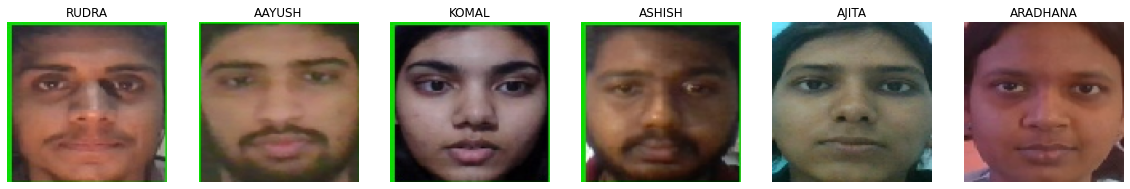

In [9]:
siamese_Net.show_base_imgs()

In [10]:
gei_data = "/content/drive/MyDrive/GEI_Ashish/GaitDataset"
paths = {}

for i in range(0, 198, 18):
  paths[f'gei_{i}'] = gei_data + "/" + '0'*(3-len(str(i))) + str(i)

paths

{'gei_0': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/000',
 'gei_108': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/108',
 'gei_126': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/126',
 'gei_144': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/144',
 'gei_162': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/162',
 'gei_18': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/018',
 'gei_180': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/180',
 'gei_36': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/036',
 'gei_54': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/054',
 'gei_72': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/072',
 'gei_90': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/090'}

In [11]:
os.listdir(paths["gei_0"]+'//'+'train')

['001', '003', '005', '002', '004', '006']

# Preparing DataFrame

{

'Aayush':'001',
'Ajita':'002',
'Aradhana':'003',
'Ashish':'004',
'Komal':'005',
'Rudra':'006'

}

In [197]:
unMasked_features_label = {'Uface':[],
                  '0_deg':[],
                  '54_deg':[],
                  '90_deg':[],
                  'label':[]
                  }

masked_features_label = {'Mface':[],
                  '0_deg':[],
                  '54_deg':[],
                  '90_deg':[],
                  'label':[]
                  }
                  
angles = [0, 54, 90]
for angle in angles:
    angle_count = 0
    labels = []
    print(f"==============Doing for angle {angle}==============")
    for class_ in range(1,7):
        img_dir = os.listdir(os.path.join(paths[f'gei_{angle}'], 'train', f'00{class_}'))
        print(f"Inside 00{class_} folder")
        i = 0
        for img in img_dir:
            i+=1
            curImg = cv2.imread(os.path.join(paths[f'gei_{angle}'], 'train', f'00{class_}', img))
            curImg = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
            curImg = cv2.resize(curImg, (224, 224))
            unMasked_features_label[f'{angle}_deg'].append(curImg)
            masked_features_label[f'{angle}_deg'].append(curImg)
            
            if (len(unMasked_features_label['label']) < 180):
                unMasked_features_label['label'].append(class_)  
                masked_features_label['label'].append(class_)

            if (i==30):
                break

        print(f"Collected {i} images")
    angle_count += 1

==============Doing for angle 0==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images
==============Doing for angle 54==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images
==============Doing for angle 90==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images


In [198]:
Counter(masked_features_label['label'])

Counter({1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30})

In [199]:
train_path = "./Face_dataset//train"
test_path = "./Face_dataset//test"

print("============================ Inside training folder ============================")
for class_ in sorted(os.listdir(train_path)):
    img_count = 0
    for img in os.listdir(os.path.join(train_path, class_)):
        img_count += 1
        curImg = cv2.imread(os.path.join(train_path, class_, img))
        curImg  = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        curImg = cv2.resize(curImg, (100, 100))
        unMasked_features_label['Uface'].append(curImg)
    print(f"Collected {img_count} images from {class_} folder")

print()
print("============================ Inside training folder ============================")
for class_ in sorted(os.listdir(test_path)):
    imgs = []
    for img in os.listdir(os.path.join(test_path, class_)):
        curImg = cv2.imread(os.path.join(test_path, class_, img))
        curImg  = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        curImg = cv2.resize(curImg, (100, 100))
        imgs.append(curImg)
    print(f"Collected {len(imgs)} images from {class_} folder")
    masked_features_label['Mface'].extend(imgs*3)


============================ Inside training folder ============================
Collected 30 images from Aayush folder
Collected 30 images from Ajita folder
Collected 30 images from Aradhana folder
Collected 30 images from Ashish folder
Collected 30 images from Komal folder
Collected 30 images from Rudra folder

============================ Inside training folder ============================
Collected 10 images from Aayush folder
Collected 10 images from Ajita folder
Collected 10 images from Aradhana folder
Collected 10 images from Ashish folder
Collected 10 images from Komal folder
Collected 10 images from Rudra folder


In [200]:
unMasked_data = pd.DataFrame(unMasked_features_label)
masked_data = pd.DataFrame(masked_features_label)

In [201]:
unMasked_data['label'] = unMasked_data['label'].apply(lambda x : x-1)
masked_data['label'] = masked_data['label'].apply(lambda x: x-1)

In [202]:
unMasked_data.sample(3)

,Uface,0_deg,54_deg,90_deg,label
104,"[[[13, 222, 6], [9, 218, 2], [10, 219, 2], [10...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
159,"[[[8, 223, 0], [8, 220, 0], [11, 220, 3], [13,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5
66,"[[[173, 111, 124], [120, 64, 77], [89, 42, 54]...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [203]:
masked_data.sample(3)

,Mface,0_deg,54_deg,90_deg,label
133,"[[[13, 218, 0], [16, 216, 5], [19, 213, 10], [...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4
113,"[[[11, 223, 1], [7, 219, 0], [10, 219, 1], [12...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
76,"[[[189, 90, 85], [185, 92, 89], [177, 95, 92],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [204]:
unMasked_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Uface   180 non-null    object
 1   0_deg   180 non-null    object
 2   54_deg  180 non-null    object
 3   90_deg  180 non-null    object
 4   label   180 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.2+ KB


In [206]:
masked_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mface   180 non-null    object
 1   0_deg   180 non-null    object
 2   54_deg  180 non-null    object
 3   90_deg  180 non-null    object
 4   label   180 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.2+ KB


In [207]:
class_enc = {0:'Aayush', 1:'Ajita', 2:'Aradhana', 3:'Ashish', 4:'Komal', 5:'Rudra'}
unMasked_data["class_name"] = unMasked_data['label'].apply(lambda x: class_enc[x])
masked_data['class_name'] = masked_data['label'].apply(lambda x : class_enc[x])

In [208]:
masked_data

,Mface,0_deg,54_deg,90_deg,label,class_name
0,"[[[8, 221, 5], [8, 220, 4], [9, 219, 3], [13, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,Aayush
1,"[[[16, 221, 6], [13, 218, 3], [12, 216, 2], [1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,Aayush
2,"[[[8, 221, 5], [8, 220, 4], [9, 219, 3], [13, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,Aayush
3,"[[[10, 220, 1], [9, 218, 0], [9, 216, 1], [13,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,Aayush
4,"[[[11, 222, 3], [10, 220, 2], [10, 218, 3], [1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,Aayush
...,...,...,...,...,...,...
175,"[[[41, 28, 35], [39, 26, 33], [44, 28, 34], [4...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,Rudra
176,"[[[28, 21, 29], [31, 25, 32], [33, 26, 33], [3...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,Rudra
177,"[[[29, 23, 27], [29, 23, 27], [35, 26, 31], [4...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,Rudra
178,"[[[27, 22, 26], [25, 20, 24], [29, 22, 29], [3...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,Rudra


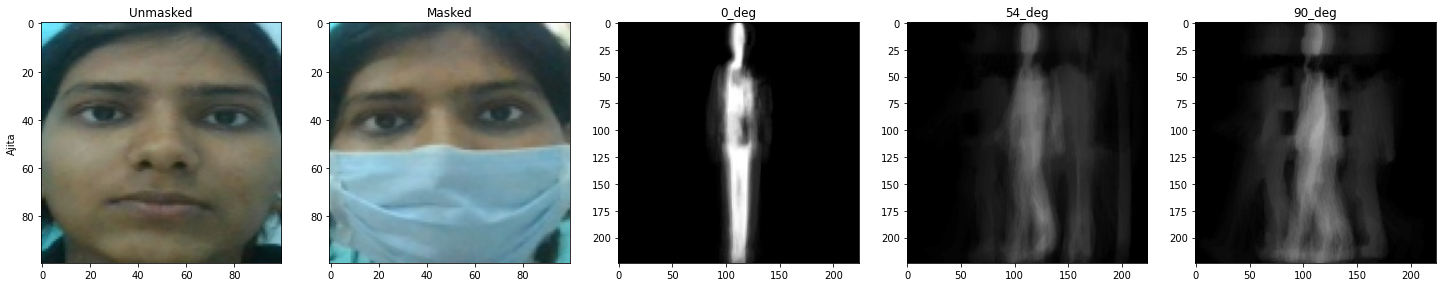

In [210]:
num = np.random.randint(len(unMasked_data))
plt.figure(figsize = (25, 12))
plt.subplot(1, 5, 1)
plt.ylabel(unMasked_data['class_name'][num])
plt.title('Unmasked')
plt.imshow(unMasked_data['Uface'][num])
plt.subplot(1, 5, 2)
plt.title(masked_data['class_name'][num])
plt.title('Masked')
plt.imshow(masked_data['Mface'][num])
plt.subplot(1, 5, 3)
plt.title(masked_data['class_name'][num])
plt.title('0_deg')
plt.imshow(masked_data['0_deg'][num])
plt.subplot(1, 5, 4)
plt.title(masked_data['class_name'][num])
plt.title('54_deg')
plt.imshow(masked_data['54_deg'][num])
plt.subplot(1, 5, 5)
plt.title(masked_data['class_name'][num])
plt.title('90_deg')
plt.imshow(masked_data['90_deg'][num])

plt.show();

# Saving the data inside Drive

In [212]:
if not os.path.exists(".//drive//MyDrive//FaceGeiCombo_0_54_90"):
    if os.path.exists(".//FaceGeiCombo_0_54_90"):
        !rm -rf .//FaceGeiCombo_0_54_90
    os.mkdir(".//FaceGeiCombo_0_54_90")
    unMasked_data.to_csv(".//FaceGeiCombo_0_54_90//unMasked_gei_combo.csv", index=False)
    masked_data.to_csv(".//FaceGeiCombo_0_54_90//masked_gei_combo.csv", index = False)
    !cp -r .//FaceGeiCombo_0_54_90 .//drive//MyDrive

In [213]:
!ls -lh ./FaceGeiCombo_0_54_90 

total 672K
-rw-r--r-- 1 root root 333K Jan 23 09:32 masked_gei_combo.csv
-rw-r--r-- 1 root root 333K Jan 23 09:32 unMasked_gei_combo.csv


<h1>Ensembling</h1>
<p><a href="https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/">click here</a> to find the resource </p>

In [214]:
np.array([unMasked_data['0_deg']]).shape

(1, 180)

In [215]:
np.array([unMasked_data['0_deg'][0]]).shape

(1, 224, 224, 3)

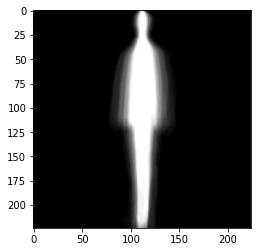

In [216]:
plt.imshow(unMasked_data['0_deg'][0])
plt.show();

In [128]:
uMgei_models = {'Uface' : siamese_Net, 
                '0_deg': mobnet_0,
                '54_deg':mobnet_54,
                '90_deg':mobnet_90
                }
mgei_models = {'Mface' : siamese_Net, 
                '0_deg': mobnet_0,
                '54_deg':mobnet_54,
                '90_deg':mobnet_90
                }
n_models = len(mgei_models)

In [165]:
uface_preds = []
mface_preds = []
gei_0_preds = []
gei_54_preds = []
gei_90_preds = []

for img in tqdm(unMasked_data['Uface']):
    uface_preds.append(siamese_Net.predict(img))

for img in tqdm(masked_data['Mface']):
    mface_preds.append(siamese_Net.predict(img))

for img in tqdm(unMasked_data['0_deg']):
    gei_0_preds.append(mobnet_0.predict(np.array([img])))

for img in tqdm(unMasked_data['54_deg']):
    gei_54_preds.append(mobnet_54.predict(np.array([img])))

for img in tqdm(unMasked_data['90_deg']):
    gei_90_preds.append(mobnet_90.predict(np.array([img])))

100%|██████████| 180/180 [00:15<00:00, 11.92it/s]


In [185]:
gei_0_preds = np.squeeze(gei_0_preds, axis = 1)
gei_54_preds = np.squeeze(gei_54_preds, axis = 1)
gei_90_preds = np.squeeze(gei_90_preds, axis = 1)

In [186]:
uface_preds = np.array(uface_preds)
mface_preds = np.array(mface_preds)
gei_0_preds = np.array(gei_0_preds)
gei_54_preds = np.array(gei_54_preds)
gei_90_preds = np.array(gei_90_preds)

In [188]:
uface_preds.shape

(180, 6)

In [187]:
gei_0_preds.shape

(180, 6)

In [217]:
preds = []
for i in range(len(mface_preds)):
   preds.append(np.argmax(uface_preds[i]))
Counter(preds)

Counter({1: 27, 2: 51, 3: 39, 4: 25, 5: 38})

In [218]:
yhats_unMasked = np.array([uface_preds, gei_0_preds, gei_54_preds, gei_90_preds])
yhats_masked = np.array([mface_preds, gei_0_preds, gei_54_preds, gei_90_preds])
y_actual = unMasked_data['label'].values
print(f"Shape of yhats_unMasked : {yhats_unMasked.shape}")
print(f"Shape of yhats_masked : {yhats_masked.shape}")
print(f"Shape of actual_label : {y_actual.shape}")

Shape of yhats_unMasked : (4, 180, 6)
Shape of yhats_masked : (4, 180, 6)
Shape of actual_label : (180,)


## Equal Weights

In [225]:
weights = [1.0/n_models]*n_models
w_sum_pred = np.tensordot(yhats_masked, weights, axes=((0), (0)))
result = np.argmax(w_sum_pred, axis = 1)
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5])

In [226]:
weights

[0.25, 0.25, 0.25, 0.25]

In [227]:
mface_preds[0].shape

(6,)

In [228]:
y_actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5])

In [229]:
accuracy_score(result, y_actual)*100

94.44444444444444

## Uneven Weights

In [230]:
weights = [0.1, 0.2, 0.4, 0.8]
w_sum_pred = np.tensordot(yhats_masked, weights, axes=((0), (0)))
result = np.argmax(w_sum_pred, axis = 1)
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5])

In [231]:
weights

[0.1, 0.2, 0.4, 0.8]

In [232]:
mface_preds[0].shape

(6,)

In [233]:
y_actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5])

In [234]:
accuracy_score(result, y_actual)*100

100.0